In [1]:
from tqdm import tqdm
from glob import glob
from matplotlib.colors import ListedColormap
from EmbedSeg.utils.preprocess_data import extract_data, split_train_val, get_data_properties
from EmbedSeg.utils.generate_crops import *
from EmbedSeg.utils.visualize import visualize_many_crops, visualize
from EmbedSeg.train import begin_training
from EmbedSeg.utils.create_dicts import create_dataset_dict, create_model_dict, create_loss_dict, create_configs, create_test_configs_dict
from EmbedSeg.test import begin_evaluating
import tifffile, numpy as np, os, json, torch
%matplotlib inline

### Download data

>The images and corresponding masks are downloaded from an external url, specified by `zip_url` to the path specified by the variables `data_dir` and `project_name`, using `extract_data` function. 
Next, the `train` directories are split into `train` and `val` using `split_train_val`.

In [2]:
data_dir = '../../data'
project_name = 'dsb-2018'

In [3]:
extract_data(
    zip_url = 'https://github.com/juglab/EmbedSeg/releases/download/v0.1.0/dsb-2018.zip',
    data_dir = data_dir,
    project_name = project_name)

Created new directory ../../data
Downloaded data as ../../data/dsb-2018.zip
Unzipped data to ../../data/dsb-2018/download/


In [4]:
split_train_val(
    data_dir = data_dir,
    project_name = project_name, 
    train_val_name = 'train',
    subset = 0.15)

Created new directory : ../../data/dsb-2018/train/images/
Created new directory : ../../data/dsb-2018/train/masks/
Created new directory : ../../data/dsb-2018/val/images/
Created new directory : ../../data/dsb-2018/val/masks/
Created new directory : ../../data/dsb-2018/test/images/
Created new directory : ../../data/dsb-2018/test/masks/
Train-Val-Test Images/Masks copied to ../../data/dsb-2018


<div class="alert alert-block alert-info"> <b> Why does one reserve some data for validation? </b> <br>
What would be the consequence of reserving a large portion ($ >15 \%$ ) of your data for validation purposes?<div>
Less data for training but better variation seen in the validation set so chance to tune the model for better generalization?

### Specify desired centre location for spatial embedding of pixels
Remember that EmbedSeg works by finding out pixel distances to object centres.

>Interior pixels of an object instance can either be embedded at the `medoid`, the `approximate-medoid` or the `centroid`.

In [5]:
center = 'medoid' # 'medoid', 'approximate-medoid', 'centroid'

### Calculate some dataset specific properties

>In the next cell, we will calculate properties of the data such as `min_object_size`, `foreground_weight` etc. 
We can also specify some properties, for example, set `data_properties_dir['data_type']='16-bit'` if the images are of datatype `unsigned 16 bit` and `data_properties_dir['data_type']='8-bit'` if the images are of datatype `unsigned 8 bit`.

In [6]:
data_properties_dir = get_data_properties(data_dir, project_name, train_val_name=['train', 'val'], 
                                          test_name=['test'], mode='2d')

data_properties_dir['data_type']='8-bit'
data_type, foreground_weight, n_y, n_x, min_object_size = data_properties_dir['data_type'], int(data_properties_dir['foreground_weight']), int(data_properties_dir['n_y']), int(data_properties_dir['n_x']), int(data_properties_dir['min_object_size'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 447/447 [00:04<00:00, 103.00it/s]


Foreground weight of the `dsb-2018` dataset set equal to 10.000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 447/447 [00:15<00:00, 29.44it/s]


Minimum object size of the `dsb-2018` dataset is equal to 21
Mean object size of the `dsb-2018` dataset is equal to 515.4253561841833
Maximum object size of the `dsb-2018` dataset is equal to 3513.3220000000147
Average object size of the `dsb-2018` dataset along `x` is equal to 22.736
Std. dev object size of the `dsb-2018` dataset along `x` is equal to 13.964
Average object size of the `dsb-2018` dataset along `y` is equal to 22.566
Std. dev object size of the `dsb-2018` dataset along `y` is equal to 14.002


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 184.91it/s]


Tile size of the `dsb-2018` dataset set equal to (696, 696)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 447/447 [00:05<00:00, 80.47it/s]

Average background intensity of the `dsb-2018` dataset set equal to 8.575


<div class="alert alert-block alert-info"> <b> Which properties do we extract from the image data and the corresponding labels?</b> <br>
How do you think we can use the <i> minimum object size </i>? <i>Tile size</i>? <i>Std. deviation</i> of object sizes?
    
 In principle, minimum object size should be used while training to tell the network what is a true nucleus in the image and what is not. While cropping to avoid cropping tiles with size under the one of the minimum object size. This is so the network is always seeing the full object during training.

### Specify cropping configuration parameters

>Images and the corresponding masks are cropped into patches centred around an object instance, which are pre-saved prior to initiating the training. Note that the cropped images, masks and center-images would be saved at the path specified by `crops_dir` (The parameter `crops_dir` is set to ```./crops``` by default, which creates a directory at the same location as this notebook). 
Note that we automatically calculate  the `crop_size` by using the `avg_object_size` and `std_object_size` through the relation:  
$\text{crop_size_i} = \text{avg_obj_size_i} + \text{n_sigma} \times \text{std_obj_size_i}$ where $i \in \{x,y\}$ and `n_sigma` equals `5` by default.  
Please feel free to reduce the parameter `n_sigma` to be equal to `3-4` in case of lower GPU memory.

In [7]:
n_sigma = 5

In [8]:
def round_up_8(x):
    return (x.astype(int)+7) & (-8)

In [9]:
crops_dir = './crops'
crop_size = np.maximum(round_up_8(data_properties_dir['avg_object_size_y'] + n_sigma*data_properties_dir['stdev_object_size_y']),
round_up_8(data_properties_dir['avg_object_size_x'] + n_sigma*data_properties_dir['stdev_object_size_x']))
print("Crop size in x and y will be set equal to {}".format(crop_size))

Crop size in x and y will be set equal to 96


### Generate Crops

>Images are normalized using `min-max-percentile` scheme (by default) and then cropped and saved using the `process` method. Other options for normalization are `absolute` and `mean-std`. Here, `data_subsets` defines the directories which are processed.  

In [14]:
norm = 'min-max-percentile' # min-max-percentile, absolute, mean-std, 

In [15]:
data_subsets = ['train', 'val'] 
for data_subset in data_subsets:
    image_dir = os.path.join(data_dir, project_name, data_subset, 'images')
    instance_dir = os.path.join(data_dir, project_name, data_subset, 'masks')
    image_names = sorted(glob(os.path.join(image_dir, '*.tif'))) 
    instance_names = sorted(glob(os.path.join(instance_dir, '*.tif')))  
    for i in tqdm(np.arange(len(image_names))):
        process(image_names[i], instance_names[i], os.path.join(crops_dir, project_name), data_subset, crop_size, center, norm=norm, data_type = data_properties_dir['data_type'])
    print("Cropping of images, instances and centre_images for data_subset = `{}` done!".format(data_subset))

  0%|                                                                                                                     | 0/380 [00:00<?, ?it/s]

Created new directory : ./crops/dsb-2018/train/images/
Created new directory : ./crops/dsb-2018/train/masks/
Created new directory : ./crops/dsb-2018/train/center-medoid/


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [14:55<00:00,  2.36s/it]


Cropping of images, instances and centre_images for data_subset = `train` done!


  0%|                                                                                                                      | 0/67 [00:00<?, ?it/s]

Created new directory : ./crops/dsb-2018/val/images/
Created new directory : ./crops/dsb-2018/val/masks/
Created new directory : ./crops/dsb-2018/val/center-medoid/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [02:35<00:00,  2.32s/it]

Cropping of images, instances and centre_images for data_subset = `val` done!


### Visualize cropped images, corresponding ground truth masks and object center images 

>Some of these cropped images generated above, their label masks and the center-images are visualized.  
The label masks are colored with a glasbey-style color map stored in `new_cmap`.

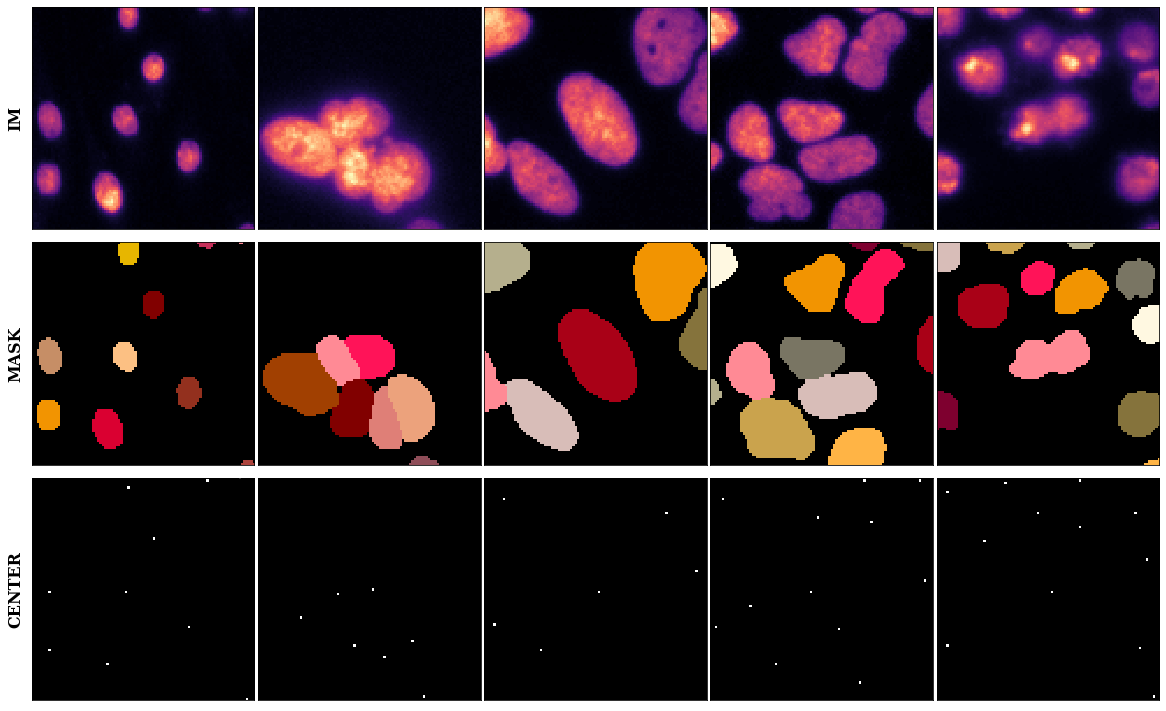

In [16]:
new_cmap = np.load('../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 
visualize_many_crops(data_dir=crops_dir, project_name=project_name, train_val_dir='val', center=center, n_images=5, new_cmp=new_cmap)

### Specify training dataset-related parameters

>We create a `train_dataset_dict` dictionary using the crops extracted from the train images and masks 

In [17]:
train_dataset_dict = create_dataset_dict(data_dir = crops_dir, 
                                         project_name = project_name,  
                                         center = center, 
                                         size = len(os.listdir(os.path.join(crops_dir, project_name, 'train', 'images'))), 
                                         batch_size = 16, 
                                         type = 'train')

`train_dataset_dict` dictionary successfully created with: 
 -- train images accessed from ./crops/dsb-2018/train/images, 
 -- number of images per epoch equal to 16301, 
 -- batch size set at 16, 
 -- virtual batch multiplier set as 1, 
 -- one_hot set as False, 


### Specify validation dataset-related parameters

>We create a `val_dataset_dict` dictionary using the crops extracted from the validation images and masks 

In [18]:
val_dataset_dict = create_dataset_dict(data_dir = crops_dir, 
                                       project_name = project_name, 
                                       center = center, 
                                       size = len(os.listdir(os.path.join(crops_dir, project_name, 'val', 'images'))), 
                                       batch_size = 16, 
                                       type ='val',)

`val_dataset_dict` dictionary successfully created with: 
 -- val images accessed from ./crops/dsb-2018/val/images, 
 -- number of images per epoch equal to 3069, 
 -- batch size set at 16, 
 -- virtual batch multiplier set as 1, 
 -- one_hot set as False, 


### Specify model-related parameters

>Set the `input_channels` attribute equal to the number of channels in the input images.  
In the cell after this one, a `model_dataset_dict` and a `loss_dict` dictionary is created.

In [19]:
model_dict = create_model_dict(input_channels = 1)
loss_dict = create_loss_dict()

`model_dict` dictionary successfully created with: 
 -- num of classes equal to 1, 
 -- input channels equal to [4, 1], 
 -- name equal to branched_erfnet
`loss_dict` dictionary successfully created with: 
 -- foreground weight equal to 10.000, 
 -- w_inst equal to 1, 
 -- w_var equal to 10, 
 -- w_seed equal to 1


### Specify the duration of training by setting `n_epochs`

>In the cell after this one, a `configs` dictionary is created.  
The model weights are saved by default at `experiment/dsb-2018-demo`

In [20]:
n_epochs = 4

In [21]:
configs = create_configs(save_dir = os.path.join('experiment', project_name+'-'+'demo'), 
                         n_epochs=n_epochs,
                         resume_path=None,
                         n_y = n_y, 
                         n_x = n_x,)

`configs` dictionary successfully created with: 
 -- n_epochs equal to 4, 
 -- display equal to False, 
 -- save_dir equal to experiment/dsb-2018-demo, 
 -- n_z equal to None, 
 -- n_y equal to 696, 
 -- n_x equal to 696, 
 -- one_hot equal to False, 


### Begin training!

>We input the dictionaries created above to the `begin_training` function.  

In [22]:
train_dataset_dict

{'name': '2d',
 'kwargs': {'center': 'center-medoid',
  'data_dir': './crops/dsb-2018',
  'type': 'train',
  'size': 16301,
  'transform': Compose(
      RandomRotationsAndFlips(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
  ),
  'one_hot': False},
 'batch_size': 16,
 'virtual_batch_multiplier': 1,
 'workers': 4}

In [23]:
%matplotlib Agg
begin_training(train_dataset_dict, val_dataset_dict, model_dict, loss_dict, configs)

2-D `train` dataloader created! Accessing data from ./crops/dsb-2018/train/
Number of images in `train` directory is 16301
Number of instances in `train` directory is 16301
Number of center images in `train` directory is 16301
*************************
2-D `val` dataloader created! Accessing data from ./crops/dsb-2018/val/
Number of images in `val` directory is 3069
Number of instances in `val` directory is 3069
Number of center images in `val` directory is 3069
*************************
Creating Branched Erfnet with [4, 1] outputs
Initialize last layer with size:  torch.Size([16, 4, 2, 2])
*************************
Created spatial emb loss function with: n_sigma: 2, foreground_weight: 10
*************************
Created logger with keys:  ('train', 'val', 'iou')
Starting epoch 0
learning rate: 0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:35<00:00,  5.41it/s]


===> train loss: 0.74
===> val loss: 0.53, val iou: 0.79
=> saving checkpoint
Starting epoch 1
learning rate: 0.0004977494364660346


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:54<00:00,  3.51it/s]


===> train loss: 0.53
===> val loss: 0.50, val iou: 0.79
=> saving checkpoint
Starting epoch 2
learning rate: 0.0004954977417064171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:49<00:00,  3.87it/s]


===> train loss: 0.50
===> val loss: 0.49, val iou: 0.79
=> saving checkpoint
Starting epoch 3
learning rate: 0.0004932449094349202


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:49<00:00,  3.87it/s]


===> train loss: 0.48
===> val loss: 0.45, val iou: 0.81
=> saving checkpoint


<div class="alert alert-block alert-info"> <b> Ideally how long should you train a model? </b><br>
What would be a good criteria to stop the training process? (<u>Hint</u> : Look at the loss curve saved in the <i>experiment/dsb2018-demo/loss.png</i>)<br>
Should the learning rate be constant for the entire training duration? How does the learning rate change after the end of each epoch, during the <i> EmbedSeg </i> model training? 

### Your model weights or the pre-trained model weights?

> Either use the model trained by you above for $4$ epochs, or use a pretrained model trained for $200$ epochs (uncomment commented lines)

In [32]:
#checkpoint_path = os.path.join('experiment', project_name+'-'+'demo', 'best_iou_model.pth')

# use the following for the pretrained model weights (pretrained models are all done using centroid setting)
torch.hub.download_url_to_file(url = 'https://owncloud.mpi-cbg.de/index.php/s/H1pXwhq3aO4kJK3/download', 
                               dst = 'pretrained_model', progress=True)
import zipfile
with zipfile.ZipFile('pretrained_model', 'r') as zip_ref:
    zip_ref.extractall('')
checkpoint_path = os.path.join(project_name+'-'+'demo', 'best_iou_model.pth')
if os.path.isfile(os.path.join(project_name+'-'+'demo','data_properties.json')): 
    with open(os.path.join(project_name+'-'+'demo', 'data_properties.json')) as json_file:
        data = json.load(json_file)
        one_hot, data_type, min_object_size, n_y, n_x, avg_bg = data['one_hot'], data['data_type'], \
        int(data['min_object_size']), int(data['n_y']), int(data['n_x']), float(data['avg_background_intensity'])
if os.path.isfile(os.path.join(project_name+'-'+'demo','normalization.json')): 
    with open(os.path.join(project_name+'-'+'demo', 'normalization.json')) as json_file:
        data = json.load(json_file)
        norm = data['norm']

0.00B [00:00, ?B/s]

### Set `tta=True` for better inference

> Setting `tta=True` leads to improved performance, but the trained model takes *longer* to predict per image.  
We set the location where the predictions of the test images are saved with `save_dir`.  
In the cell after this one, a `test_configs` dictionary is created.

In [33]:
tta = False # Try with true
save_dir = './inference/' + project_name

In [34]:
test_configs = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        tta = tta, 
                                        min_object_size = min_object_size, 
                                        save_dir = save_dir,
                                        norm = norm, 
                                        data_type = data_type,
                                        n_y = n_y,
                                        n_x = n_x,
                                        )

`test_configs` dictionary successfully created with: 
 -- evaluation images accessed from ../../data/dsb-2018, 
 -- trained weights accessed from dsb-2018-demo/best_iou_model.pth, 
 -- output directory chosen as ./inference/dsb-2018


### Evaluate on unseen test data

>The `test_configs` dictionary created above, is input to the `begin_evaluating` function.

In [35]:
%matplotlib inline
result = begin_evaluating(test_configs)

2-D `test` dataloader created! Accessing data from ../../data/dsb-2018/test/
Number of images in `test` directory is 50
Number of instances in `test` directory is 50
Number of center images in `test` directory is 0
*************************
Creating Branched Erfnet with [4, 1] outputs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.86it/s]


Mean Average Precision (AP_dsb) at IOU threshold = 0.5 at foreground threshold = 0.50000, is equal to 0.89005


In [36]:
%matplotlib inline
prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
ground_truth_file_names = sorted(glob(os.path.join(save_dir,'ground-truth','*.tif')))
seed_file_names = sorted(glob(os.path.join(save_dir,'seeds','*.tif')))
image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'test', 'images','*.tif')))

### Visualize some results on unseen test data

>Change value of `index` to see predictions on different unseen, test images.

Image filename is 0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0.tif and index is 1


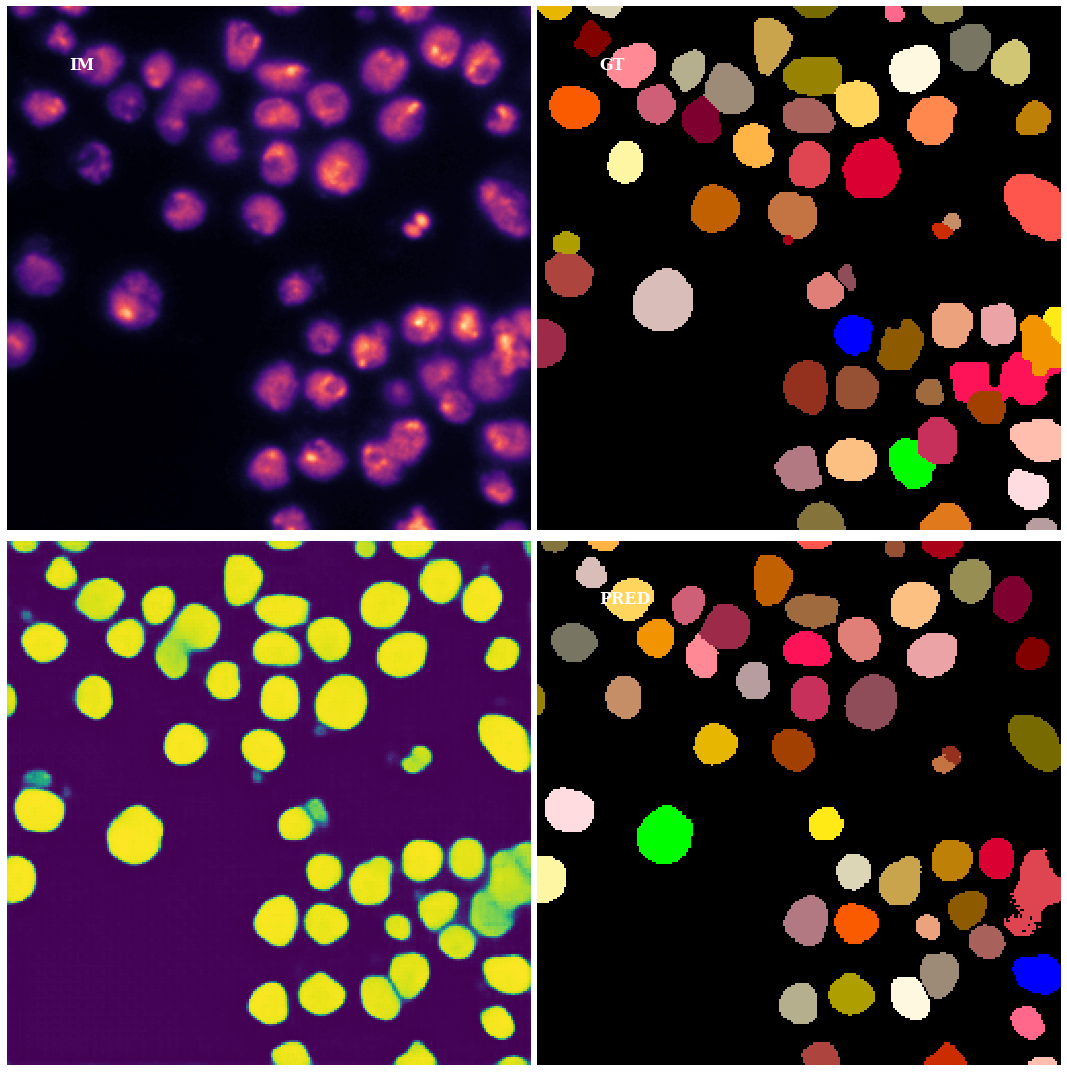

In [37]:
index = 1
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
prediction = tifffile.imread(prediction_file_names[index])
image = tifffile.imread(image_file_names[index])
seed = tifffile.imread(seed_file_names[index])
if len(ground_truth_file_names) > 0:
    ground_truth = tifffile.imread(ground_truth_file_names[index])
    visualize(image = image, prediction = prediction, ground_truth = ground_truth, seed = seed, new_cmp = new_cmap)
else:
    visualize(image = image, prediction = prediction, ground_truth = None, seed = seed, new_cmp = new_cmap)

>If you tried predictions from model trained by you, you could go back and try predictions from the longer trained model as well :)

<div class="alert alert-block alert-info"> <b> If you find a pretrained model trained on fluoroscent nuclei and wish to use it on your image data and a few, available training labels, what would be a nice strategy?</b> <br>
Does it make sense to train the complete model again on your data? How can one preserve the knowledge of the already pretrained model and also leverage the few labels without over-fitting? Should the learning rate be high? Discuss :)

<div class="alert alert-block alert-info"> <b> In which situations would the confidence of the model (<i> seed map </i>)  be low? </b> <br>
What would happen when you have sparsely labeled image data? Overlapping objects? When you train model too briefly?